# Introduction

In this notebook, we will create a convolutional neural network (CNN) to classify images. We will use the built-in dataset called Caltech 101, which consists of colored images belonging to 101 classes.

But before we begin, let's define CNN in a simpler way :books:.

> " In deep learning, a convolutional neural network (CNN) is a class of artificial neural network most commonly applied to analyze visual imagery. CNNs use a mathematical operation called convolution in place of general matrix multiplication in at least one of their layers. They are specifically designed to process pixel data and are used in image recognition and processing."[Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network).

The main idea behind CNN is to apply filters to the input data in order to extract relevant features through convolution. Additionally, CNNs utilize pooling to reduce dimensionality, making the data suitable for fully connected layers in the neural network.


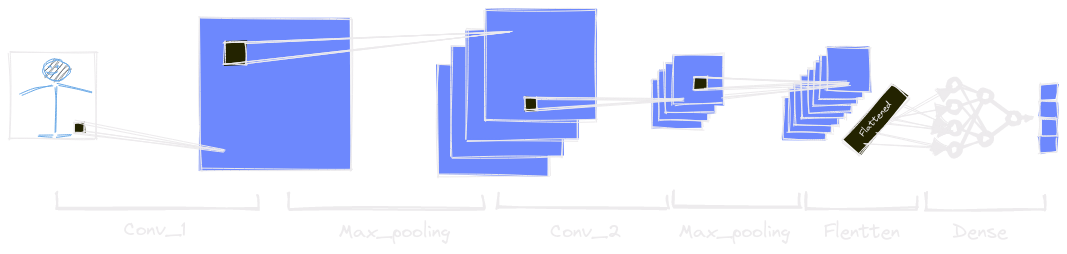


If you are unfamiliar with CNNs, there is a YouTube playlist that explains the concepts of deep learning and neural networks presented by Josh Starmer. You can find it [Here](https://youtube.com/playlist?list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1).

#### Table of contents :

- **Collecting & Getting Data**.
- **Data Analysis**.
- **Data preprocessing (Transformation / Augmentation)**.
- **Building a CNN model**.
- **Evaluate Mode**.
- **Save & Load Model**.


We need to introduce the modules and libraries that we will use and need before writing the code.

PyTorch Modules|                                  Definition
-----|----
torch.nn | it provides classes and functions for building and training neural networks by offering a high-level API for defining layers, activation functions, loss functions, optimizers, and other components.
torchvision.datasets | it provides pre-built datasets commonly used in computer vision tasks, making it easier to load and preprocess data for tasks such as image classification, object detection, and semantic segmentation.
torchvision.transforms | it provides a set of common image transformations, such as resizing, cropping, flipping, and normalization, which can be applied to images or tensors to augment and preprocess the data before feeding it into a neural network for tasks like computer vision.
torch.utils.data.DataLoader| it provides an efficient way to load and iterate over datasets. It allows you to create an iterable data loader object that automatically handles tasks like batching, shuffling, and parallel data loading, making it easier to train neural networks on large datasets.

Import Modules 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Import torchvision 
import torchvision
from torchvision import datasets, transforms
from torch.utils import data


# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [3]:
# set up device 

device ="cuda" if torch.cuda.is_available() else "cpu"
SEED=42

### 1. Collecting or Getting Data

In [4]:
# Set up the dataset
caltech101 = datasets.Caltech101(
    root="../data",
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified


In [5]:
image, label = caltech101[0]
print("the shape of image is ", image.shape )

the shape of image is  torch.Size([3, 337, 510])


In [6]:
# Define the sizes for training and test sets
train_size = int(0.8 * len(caltech101))  # 80% for training
test_size = len(caltech101) - train_size  # Remaining 20% for testing

In [7]:
# Split the dataset into training and test sets
train_dataset, test_dataset = data.random_split(caltech101, [train_size, test_size])

In [8]:
# Print the sizes of the training and test sets
print("Training set size: ",len(train_dataset))
print(f"Test set size: ",len(test_dataset))

Training set size:  6941
Test set size:  1736


### 2. Data Analysis 

Image shape: torch.Size([3, 300, 300])


Text(0.5, 1.0, '90')

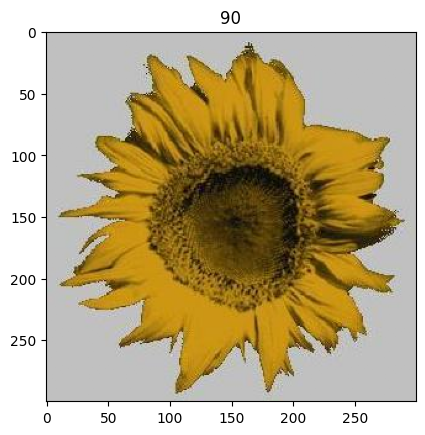

In [9]:
torch.manual_seed(SEED)
image, label = train_dataset[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1,2,0))# image shape is [3, 300, 228] (colour channels, height, width)
plt.title(label)

In [10]:
def plot_image(dataset):
    torch.manual_seed(42)
    fig = plt.figure(figsize=(10, 15))
    rows, cols = 4, 4
    for i in range(1, rows * cols + 1):
        image, label = dataset[i]
        fig.add_subplot(rows, cols, i)
        plt.imshow(image.permute(1,2,0))
        plt.title(label)

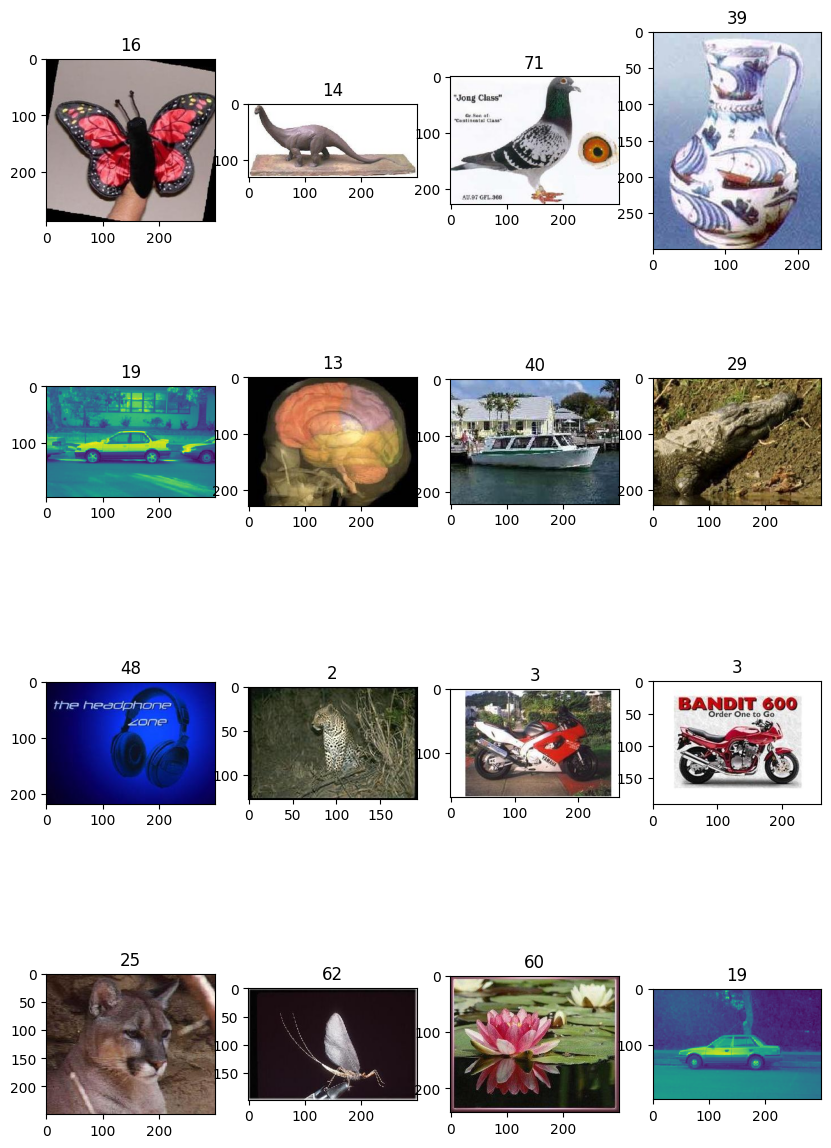

In [11]:
plot_image(train_dataset)

### 3. Data preprocessing

In [78]:
# Define transformations for training dataset
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip for data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define transformations for test dataset
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [79]:
# Apply respective transformations to train_dataset and test_dataset
train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [80]:
# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = data.DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE,# how many samples per batch?
    shuffle=True 
)

test_dataloader = data.DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [81]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader.dataset)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader.dataset)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001E71025B9A0>, <torch.utils.data.dataloader.DataLoader object at 0x000001E71025B280>)
Length of train dataloader: 6941 batches of 64
Length of test dataloader: 1736 batches of 64


### 4. Building a CNN model

In [89]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the CNN model
num_classes = 101  # Number of classes in the cealtech101 dataset
model = CNN(num_classes)


In [90]:
# Create an instance of the CNN model
num_classes = 101  # Number of classes in the cealtech101 dataset
model = CNN(num_classes)


TypeError: Linear.__init__() missing 1 required positional argument: 'out_features'

In [84]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [85]:
# Training loop
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=401408, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=101, bias=True)
  )
)

In [86]:
train_dataloader.dataset[0][0].shape

torch.Size([3, 300, 300])

In [88]:
torch.manual_seed(SEED)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    for images, labels in train_dataloader.dataset:
        images, labels = images.to(device), labels
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss / len(train_dataloader)}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x5625 and 401408x1024)